# Sample Queries from Amazon Omics Analytics

In this notebook, we will demonstrate some sample genomics queries using the Ovation Dx non-alcoholic fatty liver disease (NAFLD) example dataset (10 samples) that is available on the AWS Data Exchange. We also use variant annotations from ClinVar. 

### Pre-requisites
1. The variants and annotations have already been imported into the Omics Variant store and Annotation store
2. Appropriate resource links have been created in AWS Lake Formation.
3. The SageMaker instance role for this notebook has the necessary permissions in AWS Lake Formation.
4. We are using an Athena query engine Version 3 workgroup.


## Import Dependencies

In [1]:
import boto3, os
import pandas as pd

s3 = boto3.resource('s3')
import sys

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 105.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.25.83 requires botocore==1.27.82, but you have botocore 1.27.96 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.27.96 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [14]:
!{sys.executable} -m pip install awswrangler

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 KB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 87.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 KB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 KB 21.2 MB/s eta 0:00:00
  Attempting uninstall: asn1crypto
    Found existing installation: asn1crypto 1.4.0
    Uninsta

In [19]:
%pip install plotnine

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 101.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 91.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.8/111.8 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 KB 15.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.4
    Uninstalling pandas-1.3.4:
      Successfully uninstalled pandas-1.3.4
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.1
    Uninstalling statsmodels-0.13.1:
      Successfully uninstalled statsmodels-0.13.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python

In [20]:
import awswrangler as wr
import pandas as pd
from datetime import datetime


We will use plotnine for visualizations using ggplot.

In [22]:
from plotnine import *

In [5]:
df = wr.athena.read_sql_query("SELECT * FROM clinvar limit 10", database="ovation_claims", workgroup = "athena3")
df

,contigname,start,end,names,referenceallele,alternatealleles,qual,filters,splitfrommultiallelic,attributes,sampleid
0,10,68443355,68443356,[1205277],G,[A],NaN,None,False,"[(CLNSIG, Likely_benign), (GENEINFO, DNA2:1763...",<NA>
1,10,68444615,68444616,[669719],T,[C],NaN,None,False,"[(RS, 4237317), (CLNSIG, Benign), (GENEINFO, D...",<NA>
2,10,68444724,68444725,[1282137],C,[CA],NaN,None,False,"[(CLNSIG, Benign), (GENEINFO, DNA2:1763), (CLN...",<NA>
3,10,68444724,68444726,[1182344],CA,[C],NaN,None,False,"[(CLNSIG, Benign), (GENEINFO, DNA2:1763), (CLN...",<NA>
4,10,68444738,68444739,[1225885],A,[G],NaN,None,False,"[(CLNSIG, Benign), (GENEINFO, DNA2:1763), (CLN...",<NA>
5,10,68444758,68444759,[669718],G,[T],NaN,None,False,"[(RS, 4237318), (CLNSIG, Benign), (GENEINFO, D...",<NA>
6,10,68444902,68444903,[1397917],T,[C],NaN,None,False,"[(CLNSIG, Uncertain_significance), (GENEINFO, ...",<NA>
7,10,68444918,68444919,[1324261],A,[G],NaN,None,False,"[(CLNSIG, Likely_pathogenic), (GENEINFO, DNA2:...",<NA>
8,10,68444927,68444928,[1698835],A,[G],NaN,None,False,"[(CLNSIG, Uncertain_significance), (GENEINFO, ...",<NA>
9,10,68444985,68444986,[444217],T,[C],NaN,None,False,"[(RS, 530452383), (CLNSIG, Uncertain_significa...",<NA>


Let us join the variants to clinical annotations from ClinVar, and filter only for those that have a "Pathogenic", "Likely_pathogenic" or "Uncertain_significance" ACMG variant classifications from ClinVar. 

In [12]:
df = wr.athena.read_sql_query("SELECT variants.sampleid,variants.contigname,variants.start,\
variants.\"end\",variants.referenceallele,variants.alternatealleles,variants.attributes as variant_attributes,\
clinvar.attributes['CLNSIG'] as clinical_significance, \
SPLIT(clinvar.attributes['GENEINFO'],':')[1] as gene, \
SPLIT(clinvar.attributes['CLNDN'],'|')[1] as disorder \
FROM ovation_variants as variants \
INNER JOIN clinvar as clinvar ON \
variants.contigname=CONCAT('chr',clinvar.contigname) AND variants.start=clinvar.start AND variants.\"end\"=clinvar.\"end\" AND variants.referenceallele=clinvar.referenceallele AND variants.alternatealleles=clinvar.alternatealleles \
WHERE (clinvar.attributes['CLNSIG']='Pathogenic' OR clinvar.attributes['CLNSIG'] ='Likely_pathogenic' OR clinvar.attributes['CLNSIG']='Uncertain_significance')",\
                              database="ovation_claims", workgroup = "athena3")

In [13]:
df

,sampleid,contigname,start,end,referenceallele,alternatealleles,variant_attributes,clinical_significance,gene,disorder
0,zr5654_4_S1,chr16,66508712,66508713,T,[C],"[(CSQ, C|downstream_gene_variant|MODIFIER|TK2|...",Uncertain_significance,TK2,"Mitochondrial_DNA_depletion_syndrome,_myopathi..."
1,zr5654_22_S13,chr17,5028784,5028785,C,[CT],"[(CSQ, T|downstream_gene_variant|MODIFIER|SLC5...",Uncertain_significance,KIF1C,not_provided
2,zr5654_9_S5,chr16,47700347,47700349,CA,[C],"[(CSQ, -|3_prime_UTR_variant|MODIFIER|PHKB|ENS...",Uncertain_significance,PHKB,Glycogen_phosphorylase_kinase_deficiency
3,zr5654_10_S6,chr3,49416994,49416995,G,[A],"[(CSQ, A|upstream_gene_variant|MODIFIER|RHOA|E...",Uncertain_significance,AMT,Non-ketotic_hyperglycinemia
4,zr5654_7_S3,chr5,137618888,137618891,ATT,[A],"[(CSQ, -|3_prime_UTR_variant|MODIFIER|KLHL3|EN...",Uncertain_significance,KLHL3,Autosomal_dominant_pseudohypoaldosteronism_type_1
...,...,...,...,...,...,...,...,...,...,...
2688,zr5654_10_S6,chr5,53094195,53094196,A,[AATTATATAAACAACTTTGTAGGACT],"[(CSQ, ATTATATAAACAACTTTGTAGGACT|3_prime_UTR_v...",Uncertain_significance,ITGA2,Platelet-type_bleeding_disorder_9
2689,zr5654_18_S10,chr5,53094195,53094196,A,[AATTATATAAACAACTTTGTAGGACT],"[(CSQ, ATTATATAAACAACTTTGTAGGACT|3_prime_UTR_v...",Uncertain_significance,ITGA2,Platelet-type_bleeding_disorder_9
2690,zr5654_18_S10,chr22,17112988,17112990,GT,[G],"[(CSQ, -|3_prime_UTR_variant|MODIFIER|IL17RA|E...",Uncertain_significance,IL17RA,"Familial_Candidiasis,_Recessive"
2691,zr5654_10_S6,chr5,53094195,53094196,A,[AATTATATAAACAACTTTGTAGGACT],"[(CSQ, ATTATATAAACAACTTTGTAGGACT|3_prime_UTR_v...",Uncertain_significance,ITGA2,Platelet-type_bleeding_disorder_9


Filter the data to include only Pathogenic and Likely_pathogenic variants, and also filter out all the unknown conditions

In [45]:
df_cleaned = df[(df.gene!="") & (df.disorder !="not_provided") & (df.disorder!="See_cases") & (df.clinical_significance != 'Uncertain_significance')]

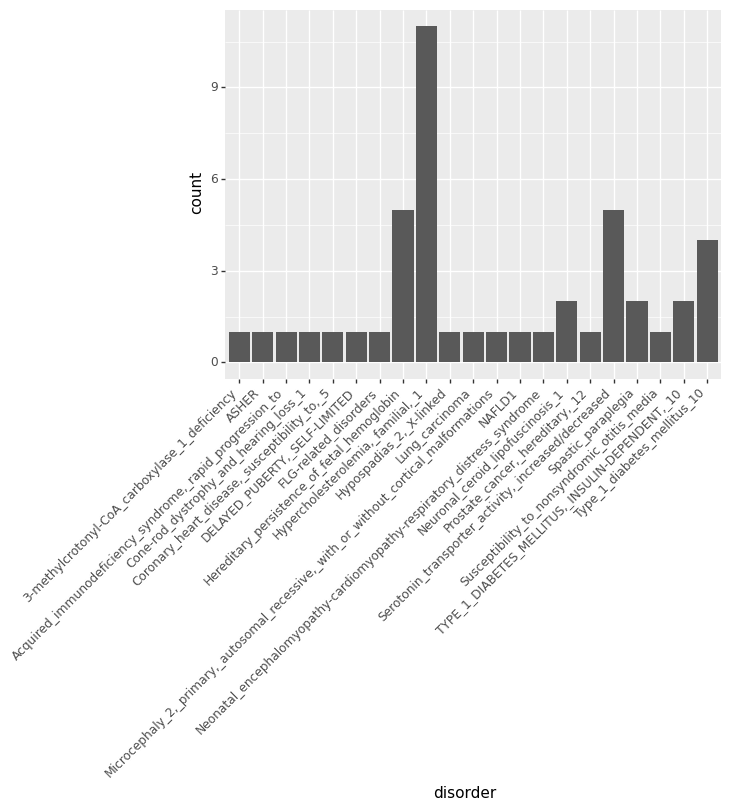

<ggplot: (8728681753784)>

In [46]:
ggplot(df_cleaned,aes('disorder')) + geom_bar()+ theme(axis_text_x= element_text(angle=45,vjust=1,hjust=1))

Let's look at conditions that occurred in more than one patient only

In [53]:
occurrences = df_cleaned.disorder.value_counts()
df_multi_occurrence = df_cleaned[df_cleaned.disorder.isin(occurrences.index[occurrences.gt(1)])]

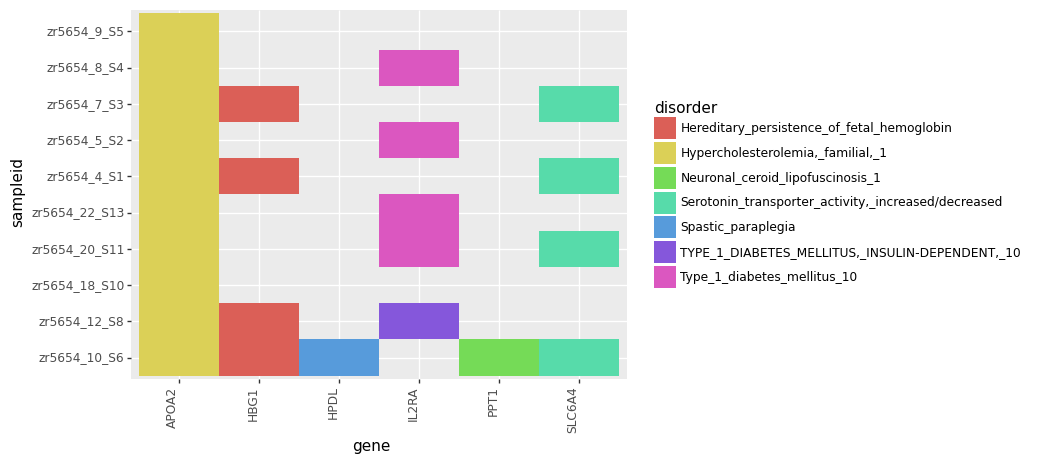

<ggplot: (8728680456409)>

In [63]:
ggplot(df_multi_occurrence,aes(x='gene',y='sampleid',fill='disorder')) + geom_tile()+ theme(axis_text_x= element_text(angle=90,vjust=1,hjust=1))



Let us find some information about the demographics of this cohort

In [65]:
df = wr.athena.read_sql_query("SELECT * FROM ovation_clinicogenomics", database="ovation_claims",workgroup = "athena3")
df

,patient_id,lab_specimen_identifier,sample_type,year_of_birth,reported_gender,state,afr_ancestry_percent,amr_ancestry_percent,eas_ancestry_percent,eur_ancestry_percent,oce_ancestry_percent,sas_ancestry_percent,was_ancestry_percent
0,1a8b4237-f568-4e82-a190-40da5f1f4b7f,zr5654_18_S10,Anterior_nasal_nares,1979,Female,MD,0.227,0.022,0.561,0.039,0.013,0.096,0.042
1,31c58fc7-620a-4288-ad77-d3e64749820b,zr5654_7_S3,Unknown,1978,Female,SC,0.212,0.043,0.475,0.052,0.123,0.094,0.001
2,5433a6d8-d6d6-4c88-b3d4-117d64b548cb,zr5654_8_S4,Unknown,2011,Female,SC,0.804,0.010,0.121,0.021,0.004,0.010,0.030
3,5b1b4d31-c689-4712-87aa-c7a76dd54abe,zr5654_5_S2,Unknown,1954,Female,SC,0.266,0.000,0.002,0.330,0.002,0.390,0.010
4,6c20fff8-0356-4203-9541-968b406888d1,zr5654_10_S6,Unknown,1967,Female,SC,0.130,0.004,0.085,0.740,0.001,0.020,0.020
5,768390eb-626b-4021-b36d-30cebc36270e,zr5654_12_S8,Unknown,1977,Female,SC,0.730,0.000,0.116,0.093,0.000,0.060,0.001
6,aca83995-da9a-4838-aee4-491df647fd1f,zr5654_4_S1,Unknown,1982,Female,SC,0.045,0.072,0.070,0.540,0.005,0.055,0.213
7,d4a39e1a-5705-4aed-b99d-0ba6571c3d5d,zr5654_9_S5,Unknown,1955,Female,SC,0.326,0.004,0.001,0.560,0.001,0.104,0.004
8,e7ff2f2b-cf9c-45e3-aaf9-8bd8b660dca9,zr5654_22_S13,Anterior_nasal_nares,1972,Male,WV,0.002,0.132,0.040,0.271,0.002,0.551,0.002
9,ec38ecc6-7487-4677-9e3e-94d1e556239f,zr5654_20_S11,Anterior_nasal_nares,1970,Male,MD,0.040,0.171,0.152,0.283,0.004,0.120,0.230
